In [1]:
######################
### DOWNLOAD DATA ###
######################

In [2]:
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from collections import defaultdict
import hdbscan
from sklearn.neighbors import KNeighborsClassifier
import geopandas as gpd
from sklearn.cluster import KMeans

path = kagglehub.dataset_download("alessandrolobello/the-ultimate-earthquake-dataset-from-1990-2023")

csv_path = os.path.join(path, os.listdir(path)[0]) # if first file is the dataset

df = pd.read_csv(csv_path)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


100%|██████████| 116M/116M [00:01<00:00, 81.9MB/s]

Extracting files...


In [3]:
######################
### PRE PROCESSING ###
######################

In [4]:
df = df.drop_duplicates()

In [5]:
df = (
    df[(df['data_type'] == 'earthquake') & (df['status'].str.lower() == 'reviewed')]
    .drop(columns=['data_type', 'status', 'date', 'time', 'depth', 'place'])
)

In [6]:
print('Before state preprocessing, there are', len(df['state'].unique()), 'unique states')

Before state preprocessing, there are 856 unique states


In [7]:
STATE_ABBR = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming",
}


COUNTRY_EQUIV = {
    "USA": "United States",
    "U.S.A.": "United States",
    "U.S.": "United States",
    "US": "United States",
    "United States of America": "United States",
    "The Netherlands": "Netherlands",
}

PLACE_SYNONYM = {
    "Cabo Verde": "Cape Verde",
    "Timor Leste": "East Timor",
    "Maldive Islands": "Maldives",
    "Hawaiian Islands": "Hawaii",
    "B.C.": "British Columbia",
    "Fiji Islands": "Fiji",
    "Philippine Islands": "Philippines",
}

SUFFIXES_TO_STRIP = [
    " region",
    " earthquake",
    " earthquake sequence",
]

CENTRAL_EXCEPTIONS = {
    "african republic",  # keep 'Central African Republic'
    "america",           # keep 'Central America'
}

# Manual overrides applied at the very end (keys are lowercase)
MANUAL_CANON_EQUIV = {
    "north island of new zealand": "New Zealand",
    "south island of new zealand": "New Zealand",
    "the north island of new zealand": "New Zealand",
    "the south island of new zealand": "New Zealand",

    "north atlantic ocean": "Atlantic Ocean",
    "south atlantic ocean": "Atlantic Ocean",
    "north pacific ocean": "Pacific Ocean",
    "south pacific ocean": "Pacific Ocean",
    "north indian ocean": "Indian Ocean",
    "south indian ocean": "Indian Ocean",

    "texas panhandle": "Texas",
    "south napa": "California",

    "northwest africa": "Africa",
    "Georgia (Sak'art'velo)": "Georgia",
    "Czechia": "Czech Republic",

    'North Macedonia': 'Macedonia',
    'Trinidad and Tobago': 'Trinidad',
    'Samoa Islands': 'Samoa',
    'Mauritius - Reunion': 'Mauritius',
    'Federated States of Micronesia': 'Micronesia',
    'U.S. Virgin Islands': 'Virgin Islands',
    'Svalbard and Jan Mayen': 'Svalbard',
    'Timor': 'East Timor',
}



# normalized maps for case-insensitive lookups
STATE_ABBR_UPPER = {k.upper(): v for k, v in STATE_ABBR.items()}
COUNTRY_EQUIV_NORM = {k.lower(): v for k, v in COUNTRY_EQUIV.items()}
PLACE_SYNONYM_NORM = {k.lower(): v for k, v in PLACE_SYNONYM.items()}
MANUAL_CANON_NORM = {k.lower(): v for k, v in MANUAL_CANON_EQUIV.items()}
US_STATES = set(STATE_ABBR.values())


# Helpers

DIRECTION_PATTERNS = [
    # "near the coast of X", "off the west coast of northern Sumatra", etc.
    r"^(?:near|off)\s+(?:the\s+)?"
    r"(?:(?:north|south|east|west|northeast|northwest|southeast|southwest)\s+)?"
    r"(?:coast of\s+)?(.*)$",

    # "north of X", "south of the Aleutian Islands", etc.
    r"^(north|south|east|west|northeast|northwest|southeast|southwest)"
    r"\s+of\s+(?:the\s+)?(.*)$",
]


def strip_leading_the(s: str) -> str:
    """
    Turn 'the Fiji Islands' -> 'Fiji Islands' (case-insensitive), but keep 'The Hague' if needed.
    """
    if s.lower().startswith("the "):
        return s[4:].strip()
    return s


def strip_directional(s: str) -> str:
    """
    Remove directional / coast phrases like:
      - 'south of X'
      - 'near the west coast of X'
      - 'the south coast of France'
      - 'northern X'
    and return the underlying region 'X'.
    """

    # 1) Patterns like "near the coast of X", "off the west coast of X", "north of X", etc.
    for pat in DIRECTION_PATTERNS:
        m = re.match(pat, s, flags=re.IGNORECASE)
        if m:
            # The last capturing group is always the place part
            inner = m.group(m.lastindex).strip()
            # Recursively strip in case we now have "northern Peru" etc.
            return strip_directional(inner)

    # 2) Patterns like "northern X", "southern X", etc. (NO 'central' here!)
    m = re.match(
        r"^(northern|southern|eastern|western|northwestern|northeastern|"
        r"southwestern|southeastern)\s+(.*)$",
        s,
        flags=re.IGNORECASE,
    )
    if m:
        inner = m.group(2).strip()
        return strip_directional(inner)

    # 3) Patterns like "the coast of X", "the north coast of X", "east coast of X"
    m = re.match(
        r"^(?:the\s+)?"
        r"(?:(?:north|south|east|west|northeast|northwest|southeast|southwest)\s+)?"
        r"coast of\s+(.*)$",
        s,
        flags=re.IGNORECASE,
    )
    if m:
        inner = m.group(1).strip()
        return strip_directional(inner)

    # If nothing matched, return as-is
    return s


def normalize_border(s: str) -> str:
    """
    Collapse 'A-B border', 'A-B-C border region', etc. to just 'A'.

    Examples:
      'California-Nevada border' -> 'California'
      'Afghanistan-Pakistan border region' -> 'Afghanistan'
      'Russia-Georgia-Azerbaijan border region' -> 'Russia'
    """
    if "border" not in s.lower():
        return s

    # Strip trailing 'border' and optional 'region'
    core = re.sub(r"(?i)\s*border(?: region)?$", "", s).strip()

    # Split on dash and keep the first non-empty chunk
    parts = re.split(r"[-–—]", core)
    parts = [p.strip() for p in parts if p.strip()]
    if parts:
        return parts[0]

    return s


def normalize_island_region(s: str) -> str:
    """
    Turn 'X Islands region' -> 'X Islands', 'X Island region' -> 'X Island'.
    """
    m = re.match(r"^(.*?)( Islands?| Island)? region$", s, flags=re.IGNORECASE)
    if m:
        base = m.group(1).strip()
        suffix = m.group(2) or ""
        return (base + suffix).strip()
    return s


def strip_generic_central(s: str) -> str:
    """
    Turn 'central X' / 'mid X' / 'middle X' into 'X',
    except for a few named exceptions like 'Central African Republic'.
    """
    m = re.match(r"^(central|mid|middle)\s+(.*)$", s, flags=re.IGNORECASE)
    if not m:
        return s

    rest = m.group(2).strip()
    if rest.lower() in CENTRAL_EXCEPTIONS:
        # keep 'Central African Republic', 'Central America', etc.
        return s

    return rest


# Main normalizer

def normalize_place(name: str) -> str:
    # trim and collapse whitespace
    s = name.strip()
    s = re.sub(r"\s+", " ", s)

    # strip leading 'the' (e.g. 'the Fiji Islands' -> 'Fiji Islands')
    s = strip_leading_the(s)

    low = s.lower()
    up = s.upper()

    # exact place synonyms (case-insensitive)
    if low in PLACE_SYNONYM_NORM:
        return PLACE_SYNONYM_NORM[low]

    # state abbreviations or country synonyms (pre), case-insensitive
    if up in STATE_ABBR_UPPER:
        return STATE_ABBR_UPPER[up]
    if low in COUNTRY_EQUIV_NORM:
        return COUNTRY_EQUIV_NORM[low]

    # remove directional phrases
    s = strip_directional(s)

    # remove 'central/mid/middle' where safe
    s = strip_generic_central(s)

    # normalize island/region patterns
    s = normalize_island_region(s)

    # normalize border regions
    s = normalize_border(s)

    # strip generic suffixes like ' region', ' Earthquake'
    for suf in SUFFIXES_TO_STRIP:
        if s.lower().endswith(suf.lower()):
            s = s[: -len(suf)].rstrip()
            break

    # final trim + collapse again just in case
    s = s.strip()
    s = re.sub(r"\s+", " ", s)

    # strip 'the' that may have been exposed by earlier rewrites
    s = strip_leading_the(s)

    # Now re-check state/country, synonyms, and manual overrides (case-insensitive)
    low = s.lower()
    up = s.upper()

    if up in STATE_ABBR_UPPER:
        return STATE_ABBR_UPPER[up]
    if low in COUNTRY_EQUIV_NORM:
        return COUNTRY_EQUIV_NORM[low]
    if low in PLACE_SYNONYM_NORM:
        return PLACE_SYNONYM_NORM[low]
    if low in MANUAL_CANON_NORM:
        return MANUAL_CANON_NORM[low]

    return s


# Grouping helper

def build_groups(raw_places):
    """
    Returns: dict[canonical_name] -> list[original_strings]
    """
    groups = defaultdict(list)
    for place in raw_places:
        canon = normalize_place(place)
        groups[canon].append(place)
    return groups


In [8]:
raw_places = df['state'].unique()

grouped = build_groups(raw_places)

# for canon in grouped.keys():
#     print(f"'{canon}' : {grouped[canon]}")

flat_map = {}

for canon, originals in grouped.items():
    for orig in originals:
        key = orig.strip()
        flat_map[key] = canon

df["Place"] = df["state"].str.strip().map(flat_map)
df.drop('state', axis=1, inplace=True)

counts = df['Place'].value_counts()

# replace rare places (<100 occurrences) with NaN
df['Place'] = df['Place'].apply(
    lambda x: x if counts.get(x, 0) >= 100 else None
)

In [9]:
print('After state preprocessing, there are', len(df['Place'].unique()), 'unique states')

After state preprocessing, there are 200 unique states


In [10]:
N_SAMPLE = 50_000

if len(df) > N_SAMPLE:
    df_sample = df.sample(n=N_SAMPLE, random_state=42)
else:
    df_sample = df.copy()

# Get sample coordinates and convert to radians
sample_coords = df_sample[["latitude", "longitude"]].values
sample_coords_rad = np.radians(sample_coords)

# Run HDBSCAN on the sample
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,   # tune these
    min_samples=10,
    metric="haversine"
)

sample_labels = clusterer.fit_predict(sample_coords_rad)  # -1 = noise
df_sample["Region_id"] = sample_labels

# Train k-NN on non-noise sample points
mask_non_noise = df_sample["Region_id"] != -1
train_coords = df_sample.loc[mask_non_noise, ["latitude", "longitude"]].values
train_labels = df_sample.loc[mask_non_noise, "Region_id"].values

knn = KNeighborsClassifier(
    n_neighbors=15,
    weights="distance",
    metric="euclidean"
)
knn.fit(train_coords, train_labels)

# Predict Region_id for ALL rows in df
all_coords = df[["latitude", "longitude"]].values
pred_labels = knn.predict(all_coords)

df["Region_id"] = pred_labels.astype("int64")

# Overwrite with original HDBSCAN labels for the sampled rows
df.loc[df_sample.index, "Region_id"] = sample_labels

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [11]:
# Compute centroids for each fine-grained Region_id
centroids = (
    df.groupby("Region_id")[["latitude", "longitude"]]
      .mean()
      .reset_index()
)

# Run KMeans on centroids to get 15 macro regions
k = 15
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
centroids["MacroRegion"] = kmeans.fit_predict(
    centroids[["latitude", "longitude"]].values
)

# Build mapping: fine Region_id -> MacroRegion
micro_to_macro = (
    centroids.set_index("Region_id")["MacroRegion"].to_dict()
)

# Apply to full dataframe
df["MacroRegion"] = df["Region_id"].map(micro_to_macro).astype("Int64")


In [12]:
df['Region_id'].value_counts() # 122 microregions + -1 indicates "noise"

,count
Region_id,
48,176884
74,121164
120,62903
20,60480
69,59820
...,...
64,9489
27,9206
107,8583


In [13]:
df['MacroRegion'].value_counts()

,count
MacroRegion,
0,1607912
2,637832
10,127929
4,126759
9,113970
7,96159
14,88490
6,74394
1,70014


In [14]:
df.columns

Index(['tsunami', 'significance', 'magnitudo', 'longitude', 'latitude',
       'Place', 'Region_id', 'MacroRegion'],
      dtype='object')

In [15]:
# Pre-Processing NEXT STEPS:
# MagnutudeClass and SignificanceClass - discrete bins for each. Refer to pre-processing section on document

In [16]:
mag_bins = [-10, 0, 1, 2, 3, 5, 10]
mag_labels = [
    "neg_or_zero",
    "0-1",
    "1-2",
    "2-3",
    "3-5",
    "5+"
]

df["Magnitude_bin"] = pd.cut(
    df["magnitudo"],
    bins=mag_bins,
    labels=mag_labels,
    include_lowest=True
)

df['Magnitude_bin'].value_counts()

,count
Magnitude_bin,
1-2,1275491
0-1,749009
3-5,495363
2-3,466487
neg_or_zero,110854
5+,42550


In [17]:
# df.drop('Significance_bin', axis=1, inplace=True)

In [18]:

sig_bins = [0, 50, 150, 400, 800, np.inf]
sig_labels = ["low", "moderate", "high", "severe", "extreme"]

sig_labels_with_ranges = [
    f"{label} ({sig_bins[i]}–{sig_bins[i+1] if sig_bins[i+1] != np.inf else 'inf'})"
    for i, label in enumerate(sig_labels)
]

df["Significance_bin"] = pd.cut(
    df["significance"],
    bins=sig_bins,
    labels=sig_labels_with_ranges,
    include_lowest=True
)

df["Significance_bin"].value_counts()

,count
Significance_bin,
low (0–50),1959146
moderate (50–150),666086
high (150–400),478807
severe (400–800),34974
extreme (800–inf),741


In [19]:
print("Columns:", df.columns)
print("Any Nulls:", df.isnull().any().any())

Columns: Index(['tsunami', 'significance', 'magnitudo', 'longitude', 'latitude',
       'Place', 'Region_id', 'MacroRegion', 'Magnitude_bin',
       'Significance_bin'],
      dtype='object')
Any Nulls: True


In [20]:
############################
### MODEL TRAINING (MLE) ###
############################

In [21]:
def counts(data):
    T = len(data)
    Magnitude_counts = {}
    State_counts = {}
    Magnitude_State_counts = {}
    Magnitude_State_Tsunami_counts = {}
    Magnitude_State_Tsunami_Significance_counts = {}


    for t in range(T):
        Magnitude_t = data[t]['Magnitude']
        State_t = data[t]['State']
        Tsunami_t = data[t]['Tsunami']
        Significance_t = data[t]['Significance']

        #add Magnitude count:
        if Magnitude_t in Magnitude_counts:
            Magnitude_counts[Magnitude_t] += 1
        else:
            Magnitude_counts[Magnitude_t] = 1

        #add State count:
        if State_t in State_counts:
            State_counts[State_t] += 1
        else:
            State_counts[State_t] = 1

        #add State and Magnitude count:
        if (Magnitude_t, State_t) in Magnitude_State_counts:
            Magnitude_State_counts[(Magnitude_t, State_t)] += 1
        else:
            Magnitude_State_counts[(Magnitude_t, State_t)] = 1

        #add Magnitude State Tsunami count:
        if (Magnitude_t, State_t, Tsunami_t) in Magnitude_State_Tsunami_counts:
           Magnitude_State_Tsunami_counts[(Magnitude_t, State_t, Tsunami_t)] += 1
        else:
            Magnitude_State_Tsunami_counts[(Magnitude_t, State_t, Tsunami_t)] = 1

        #add Magnitude State Tsunami Significance count:
        if (Magnitude_t, State_t, Tsunami_t, Significance_t) in Magnitude_State_Tsunami_Significance_counts:
           Magnitude_State_Tsunami_Significance_counts[(Magnitude_t, State_t, Tsunami_t, Significance_t)] += 1
        else:
            Magnitude_State_Tsunami_Significance_counts[(Magnitude_t, State_t, Tsunami_t, Significance_t)] = 1

    return Magnitude_counts, State_counts, Magnitude_State_counts, Magnitude_State_Tsunami_counts, Magnitude_State_Tsunami_Significance_counts

In [22]:
def MLE(data):
    '''
    Prams:
        data -> formated as [time t][data_key in ('Magnitude', 'State', 'Tsunami', 'Significance')]

    Return:
        Magnitude_CPT, dict     -> keys in (Magnitude_bucket_value), value is P(Magnitude_bucket_value)
        State_CPT, dict         -> keys in (State), value is P(State)
        Tsunami_CPT, dict       -> Keys in (Magnitude_bucket_value, State, Tsunami_binary_value), value is P(Tsunami_binary_value|Magnitude_bucket_value, State)
        Significance_CPT, dict  -> Keys in (Magnitude_bucket_value, State, Tsunami_binary_value, Significance_bucket_value), value is P(Significance_bucket_value|Magnitude_bucket_value, State, Tsunami_binary_value)
    '''

    T = len(data)

    Magnitude_counts, State_counts, Magnitude_State_counts, Magnitude_State_Tsunami_counts, Magnitude_State_Tsunami_Significance_counts = counts(data)

    Magnitude_CPT = {}
    State_CPT = {}
    Tsunami_CPT = {}
    Significance_CPT = {}

    #calculate Magnitude CPT:
    for labels in Magnitude_counts:
        Magnitude_CPT[labels] = (1/T)*Magnitude_counts[labels]

    #calculate State CPT:
    for labels in State_counts:
        State_CPT[labels] = (1/T)*State_counts[labels]

    #calculate Tsunami CPT:
    for labels in Magnitude_State_Tsunami_counts:
        Tsunami_CPT[labels] = Magnitude_State_Tsunami_counts[labels] / Magnitude_State_counts[labels[:2]]

    #calculate Significance CPT:
    for labels in Magnitude_State_Tsunami_Significance_counts:
        Significance_CPT[labels] = Magnitude_State_Tsunami_Significance_counts[labels] / Magnitude_State_Tsunami_counts[labels[:3]]

    return Magnitude_CPT, State_CPT, Tsunami_CPT, Significance_CPT

In [23]:
def counts_smaller_dag(data):
    T = len(data)
    Magnitude_counts = {}
    State_counts = {}
    Magnitude_State_counts = {}
    Magnitude_State_Significance_counts = {}


    for t in range(T):
        Magnitude_t = data[t]['Magnitude']
        State_t = data[t]['State']
        Significance_t = data[t]['Significance']

        #add Magnitude count:
        if Magnitude_t in Magnitude_counts:
            Magnitude_counts[Magnitude_t] += 1
        else:
            Magnitude_counts[Magnitude_t] = 1

        #add State count:
        if State_t in State_counts:
            State_counts[State_t] += 1
        else:
            State_counts[State_t] = 1

        #add State and Magnitude count:
        if (Magnitude_t, State_t) in Magnitude_State_counts:
            Magnitude_State_counts[(Magnitude_t, State_t)] += 1
        else:
            Magnitude_State_counts[(Magnitude_t, State_t)] = 1

        #add Magnitude State Tsunami Significance count:
        if (Magnitude_t, State_t, Significance_t) in Magnitude_State_Significance_counts:
           Magnitude_State_Significance_counts[(Magnitude_t, State_t, Significance_t)] += 1
        else:
            Magnitude_State_Significance_counts[(Magnitude_t, State_t, Significance_t)] = 1

    return Magnitude_counts, State_counts, Magnitude_State_counts, Magnitude_State_Significance_counts

In [24]:
def MLE_smaller_dag(data):
    '''
    Prams:
        data -> formated as [time t][data_key in ('Magnitude', 'State', 'Tsunami', 'Significance')]

    Return:
        Magnitude_CPT, dict     -> keys in (Magnitude_bucket_value), value is P(Magnitude_bucket_value)
        State_CPT, dict         -> keys in (State), value is P(State)
        Significance_CPT, dict  -> Keys in (Magnitude_bucket_value, State, Significance_bucket_value), value is P(Significance_bucket_value|Magnitude_bucket_value, State)
    '''

    T = len(data)

    Magnitude_counts, State_counts, Magnitude_State_counts, Magnitude_State_Significance_counts = counts_smaller_dag(data)

    Magnitude_CPT = {}
    State_CPT = {}
    Significance_CPT = {}

    #calculate Magnitude CPT:
    for labels in Magnitude_counts:
        Magnitude_CPT[labels] = (1/T)*Magnitude_counts[labels]

    #calculate State CPT:
    for labels in State_counts:
        State_CPT[labels] = (1/T)*State_counts[labels]

    #calculate Significance CPT:
    for labels in Magnitude_State_Significance_counts:
        Significance_CPT[labels] = Magnitude_State_Significance_counts[labels] / Magnitude_State_counts[labels[:2]]

    return Magnitude_CPT, State_CPT, Significance_CPT

In [25]:
##########################
### DATA VISUALIZATION ###
##########################

Distribution of Earthquake Magnitudes

In [26]:
'''
##IMPORTANT, NEEDS TO BE UPDATED ONCE MAG_BIN AND SIG_BINS ARE MADE DISCRETE

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Earthquake Features', fontsize=16)

# Distribution of 'Place'
sns.countplot(ax=axes[0, 0], y='Place', data=df, order=df['Place'].value_counts().index[:15])
axes[0, 0].set_title('Distribution of Top 15 Regions')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_ylabel('Place')

# Distribution of 'tsunami'
sns.countplot(ax=axes[0, 1], x='tsunami', data=df)
axes[0, 1].set_title('Distribution of Tsunami Occurrence')
axes[0, 1].set_xlabel('Tsunami (0: No, 1: Yes)')
axes[0, 1].set_ylabel('Count')

# Distribution of 'Significance'
sns.countplot(ax=axes[1, 0], x='Significance_bin', data=df)
axes[1, 0].set_title('Distribution of Significance')
axes[1, 0].set_xlabel('Significance')
axes[1, 0].set_ylabel('Count')

# Distribution of 'Magnitude'
sns.countplot(ax=axes[1, 1], x='Magnitude_bin', data=df)
axes[1, 1].set_title('Distribution of Magnitude')
axes[1, 1].set_xlabel('Magnitude')
axes[1, 1].set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
'''

"\n##IMPORTANT, NEEDS TO BE UPDATED ONCE MAG_BIN AND SIG_BINS ARE MADE DISCRETE\n\nfig, axes = plt.subplots(2, 2, figsize=(15, 10))\nfig.suptitle('Distribution of Earthquake Features', fontsize=16)\n\n# Distribution of 'Place'\nsns.countplot(ax=axes[0, 0], y='Place', data=df, order=df['Place'].value_counts().index[:15])\naxes[0, 0].set_title('Distribution of Top 15 Regions')\naxes[0, 0].set_xlabel('Count')\naxes[0, 0].set_ylabel('Place')\n\n# Distribution of 'tsunami'\nsns.countplot(ax=axes[0, 1], x='tsunami', data=df)\naxes[0, 1].set_title('Distribution of Tsunami Occurrence')\naxes[0, 1].set_xlabel('Tsunami (0: No, 1: Yes)')\naxes[0, 1].set_ylabel('Count')\n\n# Distribution of 'Significance'\nsns.countplot(ax=axes[1, 0], x='Significance_bin', data=df)\naxes[1, 0].set_title('Distribution of Significance')\naxes[1, 0].set_xlabel('Significance')\naxes[1, 0].set_ylabel('Count')\n\n# Distribution of 'Magnitude'\nsns.countplot(ax=axes[1, 1], x='Magnitude_bin', data=df)\naxes[1, 1].set_titl

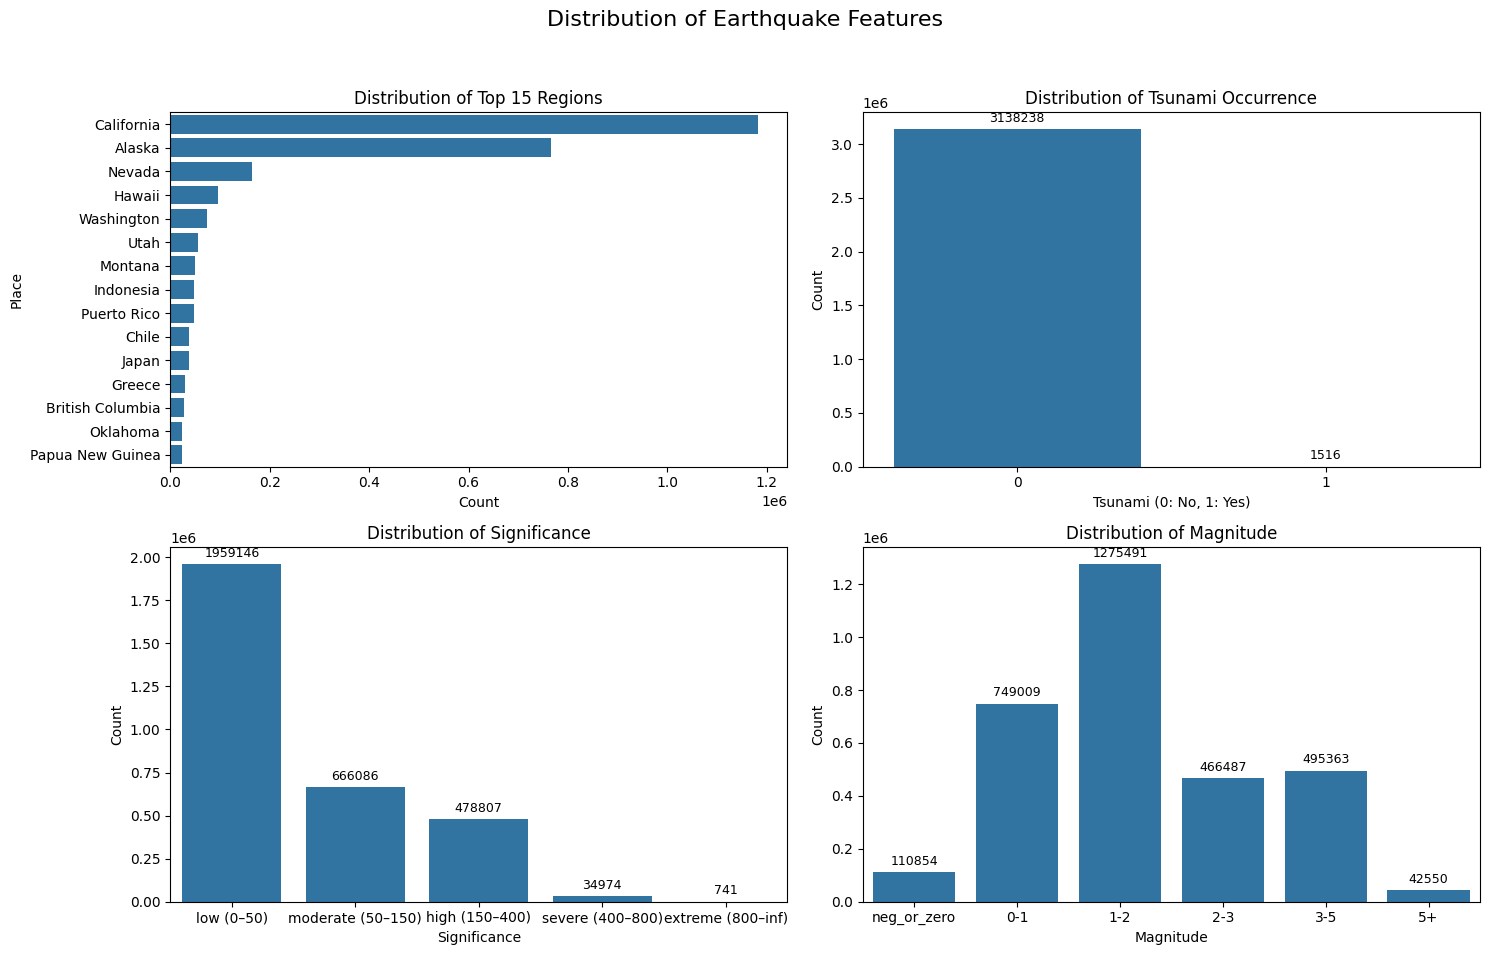

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Earthquake Features', fontsize=16)

def add_value_labels(ax):
    for p in ax.patches:
          height = p.get_height()
          ax.annotate(
              f'{int(height)}',
              (p.get_x() + p.get_width() / 2, height),
              ha='center',
              va='bottom',
              fontsize=9,
              xytext=(0, 3),
              textcoords='offset points'
          )


# Distribution of 'Place' (horizontal bars)
sns.countplot(
    ax=axes[0, 0],
    y='Place',
    data=df,
    order=df['Place'].value_counts().index[:15]
)
axes[0, 0].set_title('Distribution of Top 15 Regions')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_ylabel('Place')

# Distribution of 'tsunami'
sns.countplot(ax=axes[0, 1], x='tsunami', data=df)
axes[0, 1].set_title('Distribution of Tsunami Occurrence')
axes[0, 1].set_xlabel('Tsunami (0: No, 1: Yes)')
axes[0, 1].set_ylabel('Count')
add_value_labels(axes[0, 1])

# Distribution of 'significance'
sns.countplot(ax=axes[1, 0], x='Significance_bin', data=df)
axes[1, 0].set_title('Distribution of Significance')
axes[1, 0].set_xlabel('Significance')
axes[1, 0].set_ylabel('Count')
add_value_labels(axes[1, 0])

# Distribution of 'magnitudo'
sns.countplot(ax=axes[1, 1], x='Magnitude_bin', data=df)
axes[1, 1].set_title('Distribution of Magnitude')
axes[1, 1].set_xlabel('Magnitude')
axes[1, 1].set_ylabel('Count')
add_value_labels(axes[1, 1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


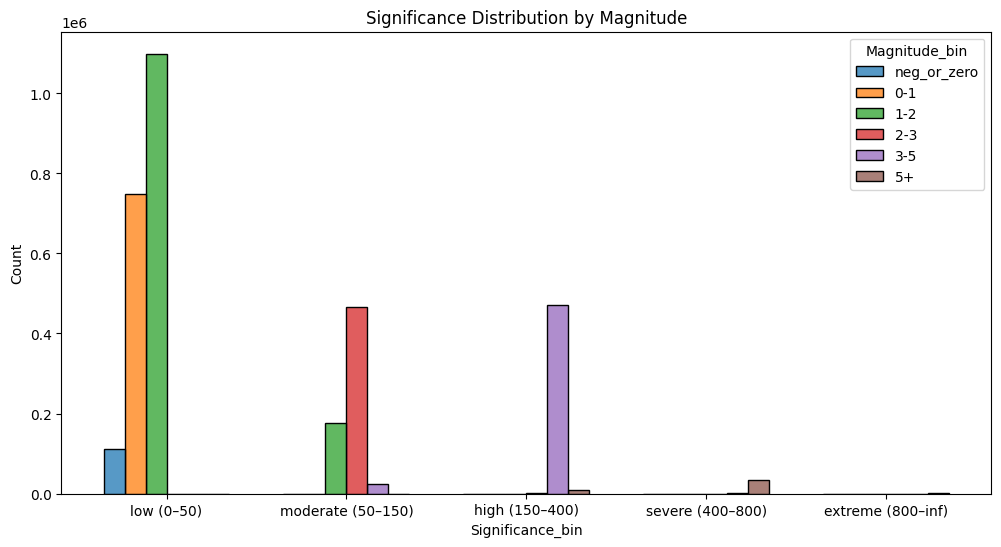

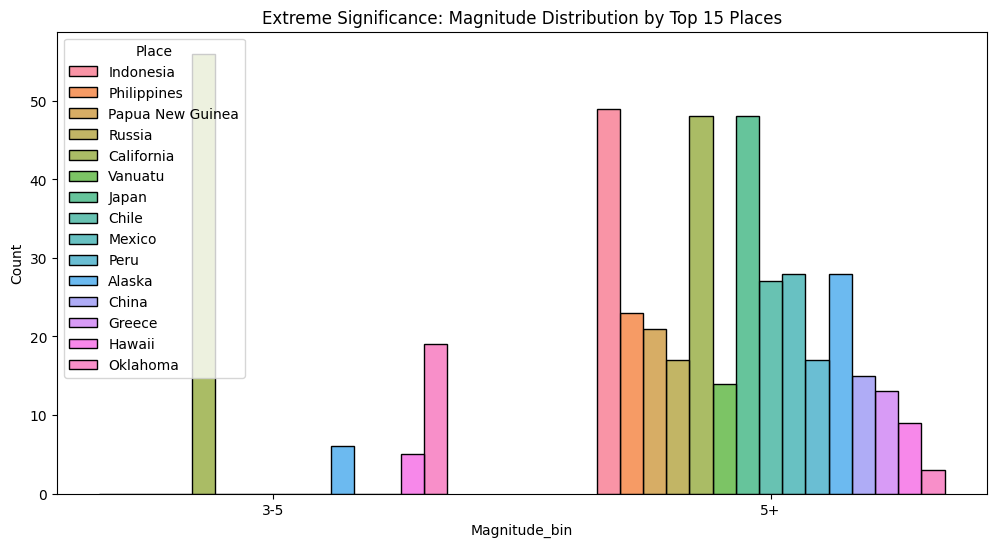

In [28]:
plt.figure(figsize=(12,6))
sns.histplot(
    data=df,
    x="Significance_bin", hue="Magnitude_bin",
    multiple="dodge", stat="count", shrink=0.7
)
plt.title("Significance Distribution by Magnitude")
plt.show()

extreme = df[df['Significance_bin'] == 'extreme (800–inf)']

# Get top 15 places for extreme events
top_places = extreme['Place'].value_counts().index[:15]
extreme_top = extreme[extreme['Place'].isin(top_places)]

plt.figure(figsize=(12, 6))
sns.histplot(
    data=extreme_top,
    x='Magnitude_bin',
    hue='Place',
    multiple='dodge',
    stat='count',
    shrink=0.7
)
plt.title("Extreme Significance: Magnitude Distribution by Top 15 Places")
plt.show()

P(Significance | Tsunami = tsunami, Significance = state, Magnitude)

Given a set state and tsunami value, see how magnitude bins affect significance

In [29]:
def significance_cpt_plot(significance_cpt, state, tsunami_val): #tsunami is 0, show how mag affects sig
#MAKE IT ITERATIVE SO WE DO NEED TO MANUALLY GO THROUGH STATES
# psuedocode:
  fig, axes = plt.subplots(2, 2, figsize=(15, 10))
  fig.suptitle('Significance Prediction according to Magnitude Shifts', fontsize=16)

#name the axis - tsunami=0  state=CA
  axes[0, 1].set_title('Significance Prediction Given that Tsunami = 0')
  axes[1, 0].set_xlabel('magnitude_bins')
  axes[1, 0].set_ylabel('Significance')


#name the axis - tsunami=1  state=CA
  axes[0, 1].set_title('Significance Prediction Given that Tsunami = 1')
  axes[1, 0].set_xlabel('magnitude_bins')
  axes[1, 0].set_ylabel('Significance')

# count all state = set state value
# count all where tsunami = set tsunami_value
# model significance based on the magnitude bins
#   for (mag, state, tsunami,significance)

In [30]:
def plot_significance_cpt(mle_data, target_state, target_tsunami_value): # Removed the 'data' parameter as it's no longer needed
    mags_seen = set()
    sigs_seen = set()
    data_for_heatmap = defaultdict(lambda: defaultdict(float))

    # Iterate through the pre-calculated CPT
    for (mag_bin, state, tsunami_val, sig_bin), prob in mle_data.items():
        if state == target_state and tsunami_val == target_tsunami_value:
            mags_seen.add(mag_bin)
            sigs_seen.add(sig_bin)
            data_for_heatmap[mag_bin][sig_bin] = prob

    if not data_for_heatmap:
        print(f"No CPT entries found for state='{target_state}' and tsunami='{target_tsunami_value}'")
        return

    # Ensure consistent order for plotting using the original labels
    ordered_mags = [m for m in mag_labels if m in mags_seen] # mag_labels is globally available
    ordered_sigs = [s for s in dynamic_labels if s in sigs_seen] # dynamic_labels is globally available

    # Create the matrix for the heatmap
    heatmap_matrix = np.zeros((len(ordered_mags), len(ordered_sigs)))

    for i, mag_bin in enumerate(ordered_mags):
        for j, sig_bin in enumerate(ordered_sigs):
            heatmap_matrix[i, j] = data_for_heatmap[mag_bin][sig_bin]

    plt.figure(figsize=(10, 7))
    sns.heatmap(
        heatmap_matrix,
        xticklabels=ordered_sigs,
        yticklabels=ordered_mags,
        annot=True, # Show probabilities on the heatmap
        cmap="viridis",
        fmt=".3f" # Format annotations to 3 decimal places
    )
    plt.xlabel("Significance Bin (P(Sig | Mag, State, Tsunami))")
    plt.ylabel("Magnitude Bin")
    plt.title(f"P(Significance | Magnitude, State='{target_state}', Tsunami={target_tsunami_value})")
    plt.tight_layout()
    plt.show()

In [31]:
# Build data in the format expected by MLE

mle_data = []
for _, row in df.iterrows():
    mle_data.append({
        'Magnitude': row['Magnitude_bin'],
        'State': row['Place'],
        'Tsunami': row['tsunami'],
        'Significance': row['Significance_bin']
    })

# Calculate CPTs
Magnitude_CPT, State_CPT, Tsunami_CPT, Significance_CPT = MLE(mle_data)
Magnitude_CPT_smaller, State_CPT_smaller, Significance_CPT_smaller = MLE_smaller_dag(mle_data)

print("Magnitude CPT:", Magnitude_CPT)
print("State CPT:", State_CPT)
print("Tsunami CPT:", Tsunami_CPT)
print("Significance CPT:", Significance_CPT)

print("Smaller Magnitude CPT:", Magnitude_CPT_smaller)
print("Smaller State CPT:", State_CPT_smaller)
print("Smaller Significance CPT:", Significance_CPT_smaller)

# plot_significance_cpt(Significance_CPT, 'California', 1)

Magnitude CPT: {'2-3': 0.14857437875706184, '1-2': 0.40623915122012744, '0-1': 0.23855658755431156, '3-5': 0.15777127762238696, '5+': 0.013552017132552422, 'neg_or_zero': 0.035306587713559726}
State CPT: {'Alaska': 0.24376145392282322, 'Hawaii': 0.030770882049994997, 'California': 0.37646261458700264, 'Washington': 0.023330808719409225, 'Greece': 0.00975777083172758, 'Italy': 0.006014802433566451, 'Albania': 0.0007815898952593101, 'Utah': 0.017934526080705684, 'Fiji': 0.005869568125400907, 'Japan': 0.011757290539322507, None: 0.0015227307617093567, 'Indonesia': 0.0153776378658965, 'Solomon Islands': 0.0024387260912797624, 'East Timor': 0.0015434330205487436, 'British Columbia': 0.009001023647075534, 'Switzerland': 0.00039238742907883866, 'New Caledonia': 0.0008303198276043282, 'Colombia': 0.0010991306962265196, 'Nevada': 0.052171284756703865, 'Wyoming': 0.0038713224029653277, 'Philippines': 0.005674966892310671, 'Mid-Atlantic Ridge': 0.0016208276189790664, 'Papua New Guinea': 0.0072961

In [32]:
# Filter the DataFrame for California and tsunami=1
california_tsunami_data = df[(df['Place'] == 'California') & (df['tsunami'] == 0)]

print(f"Number of data points for California and tsunami=1: {len(california_tsunami_data)}")

if not california_tsunami_data.empty:
    print("\nDistribution of Magnitude_bin and Significance_bin for California with Tsunami=1:")
    display(pd.crosstab(california_tsunami_data['Magnitude_bin'], california_tsunami_data['Significance_bin']))
else:
    print("No data points found for California with tsunami=1.")


Number of data points for California and tsunami=1: 1181855

Distribution of Magnitude_bin and Significance_bin for California with Tsunami=1:


Significance_bin,low (0–50),moderate (50–150),high (150–400),severe (400–800),extreme (800–inf)
Magnitude_bin,,,,,
neg_or_zero,18482,1,0,0,0
0-1,441045,1,0,0,0
1-2,530981,61823,3,0,0
2-3,0,116047,428,45,0
3-5,0,2868,9535,444,37
5+,0,0,11,71,33


In [33]:
# # Get the top N most frequent places to plot
# top_n = 5
# top_places = df['Place'].value_counts().nlargest(top_n).index.tolist()

# # Define the tsunami values to plot for
# tsunami_values_to_plot = [0, 1]
# print(f"Generating CPT heatmaps for the top {top_n} places for both tsunami=0 and tsunami=1:\n")

# for place in top_places:
#     for tsunami_val in tsunami_values_to_plot:
#         print(f"Plotting for Place: {place}, Tsunami: {tsunami_val}")
#         plot_significance_cpt(Significance_CPT, place, tsunami_val)


In [34]:

def format_table_with_borders(df, index_name="Magnitude"):
    df_formatted = df.copy()
    for col in df_formatted.columns:
        df_formatted[col] = df_formatted[col].apply(
            lambda x: f"{x:.4f}" if pd.notna(x) and isinstance(x, (int, float)) else "  N/A  "
        )

    cols = df_formatted.columns.tolist()
    index_vals = df_formatted.index.tolist()

    col_widths = {}
    for col in cols:
        col_str = str(col)
        max_val_width = max([len(str(df_formatted.loc[idx, col])) for idx in index_vals], default=0)
        col_widths[col] = max(len(col_str), max_val_width, 8)  # Minimum width of 8

    index_width = max(len(index_name), max([len(str(idx)) for idx in index_vals], default=0), 10)  # Minimum width of 10

    # Build the table
    lines = []

    # Top border
    top_border = "┌" + "─" * index_width + "┬" + "┬".join(["─" * (col_widths[col] + 2) for col in cols]) + "┐"
    lines.append(top_border)

    # Header row
    header = "│" + index_name.center(index_width) + "│"
    for col in cols:
        col_display = str(col)
        # Truncate if too long, but try to keep it readable
        if len(col_display) > col_widths[col]:
            col_display = col_display[:col_widths[col]-3] + "..."
        header += col_display.center(col_widths[col] + 2) + "│"
    lines.append(header)

    # Header separator
    header_sep = "├" + "─" * index_width + "┼" + "┼".join(["─" * (col_widths[col] + 2) for col in cols]) + "┤"
    lines.append(header_sep)

    # Data rows
    for idx in index_vals:
        row = "│" + str(idx).ljust(index_width) + "│"
        for col in cols:
            val = str(df_formatted.loc[idx, col])
            row += val.center(col_widths[col] + 2) + "│"
        lines.append(row)

    # Bottom border
    bottom_border = "└" + "─" * index_width + "┴" + "┴".join(["─" * (col_widths[col] + 2) for col in cols]) + "┘"
    lines.append(bottom_border)

    return "\n".join(lines)

In [35]:
print("="*80)
print("MLE (FULL DAG) CPTs")
print("="*80)

print("\n1. Magnitude CPT: P(Magnitude)")
mag_df = pd.DataFrame(list(Magnitude_CPT.items()), columns=['Magnitude', 'Probability'])
mag_df = mag_df.sort_values('Magnitude')
mag_df['Probability'] = mag_df['Probability'].apply(lambda x: f"{x:.6f}")
print(mag_df.to_string(index=False))

print("\n2. State CPT: P(State) - Top 20 States")
state_df = pd.DataFrame(list(State_CPT.items()), columns=['State', 'Probability'])
state_df = state_df.sort_values('Probability', ascending=False)
state_df['Probability'] = state_df['Probability'].apply(lambda x: f"{x:.6f}")
print(state_df.head(20).to_string(index=False))
print(f"\n... (Total: {len(state_df)} states)")

print("\n3. Tsunami CPT: P(Tsunami | Magnitude, State) - Sample Entries")
tsunami_list = []
for (mag, state, tsunami), prob in Tsunami_CPT.items():
    tsunami_list.append({
        'Magnitude': mag,
        'State': state,
        'Tsunami': tsunami,
        'Probability': prob
    })
tsunami_df = pd.DataFrame(tsunami_list)
tsunami_df = tsunami_df.sort_values(['State', 'Magnitude', 'Tsunami'])
tsunami_df['Probability'] = tsunami_df['Probability'].apply(lambda x: f"{x:.6f}")
print(tsunami_df.head(30).to_string(index=False))
print(f"\n... (Total: {len(tsunami_df)} entries)")

print("\n4. Significance CPT: P(Significance | Magnitude, State, Tsunami)")

top_states = state_df.head(5)['State'].tolist()

sig_list = []
for (mag, state, tsunami, sig), prob in Significance_CPT.items():
    sig_list.append({
        'Magnitude': mag,
        'State': state,
        'Tsunami': tsunami,
        'Significance': sig,
        'Probability': prob
    })
sig_df = pd.DataFrame(sig_list)

def get_sig_order(sig_str):
    sig_lower = sig_str.lower()
    if sig_lower.startswith('low'):
        return 0
    elif sig_lower.startswith('moderate'):
        return 1
    elif sig_lower.startswith('high'):
        return 2
    elif sig_lower.startswith('severe'):
        return 3
    elif sig_lower.startswith('extreme'):
        return 4
    else:
        return 999

sig_values = sorted(sig_df['Significance'].unique(), key=get_sig_order)
mag_values = sorted(sig_df['Magnitude'].unique(), key=lambda x: mag_labels.index(x) if x in mag_labels else 999)

for state in top_states:
    for tsunami_val in [0, 1]:
        state_tsunami_data = sig_df[(sig_df['State'] == state) & (sig_df['Tsunami'] == tsunami_val)]
        if len(state_tsunami_data) > 0:
            pivot = state_tsunami_data.pivot_table(
                values='Probability',
                index='Magnitude',
                columns='Significance',
                aggfunc='first'
            )
            pivot = pivot.reindex([m for m in mag_values if m in pivot.index])
            # Ensure all significance columns are included, even if empty
            pivot = pivot.reindex(columns=sig_values)

            print(f"\n   State: {state}, Tsunami: {tsunami_val}")
            print("   " + "="*80)

            print(format_table_with_borders(pivot, index_name="Magnitude"))
            print()

print(f"\n   (Total entries in full CPT: {len(sig_df)})")


MLE (FULL DAG) CPTs

1. Magnitude CPT: P(Magnitude)
  Magnitude Probability
        0-1    0.238557
        1-2    0.406239
        2-3    0.148574
        3-5    0.157771
         5+    0.013552
neg_or_zero    0.035307

2. State CPT: P(State) - Top 20 States
           State Probability
      California    0.376463
          Alaska    0.243761
          Nevada    0.052171
          Hawaii    0.030771
      Washington    0.023331
            Utah    0.017935
         Montana    0.015934
       Indonesia    0.015378
     Puerto Rico    0.015176
           Chile    0.011822
           Japan    0.011757
          Greece    0.009758
British Columbia    0.009001
        Oklahoma    0.007881
Papua New Guinea    0.007296
           Italy    0.006015
            Fiji    0.005870
     Philippines    0.005675
          Mexico    0.005252
          Turkey    0.005195

... (Total: 200 states)

3. Tsunami CPT: P(Tsunami | Magnitude, State) - Sample Entries
  Magnitude            State  Tsunami Prob

In [36]:
print("\n" + "="*80)
print("MLE SMALLER DAG CPTs")
print("="*80)

print("\n1. Magnitude CPT: P(Magnitude)")
mag_df_smaller = pd.DataFrame(list(Magnitude_CPT_smaller.items()), columns=['Magnitude', 'Probability'])
mag_df_smaller = mag_df_smaller.sort_values('Magnitude')
mag_df_smaller['Probability'] = mag_df_smaller['Probability'].apply(lambda x: f"{x:.6f}")
print(mag_df_smaller.to_string(index=False))

print("\n2. State CPT: P(State) - Top 20 States")
state_df_smaller = pd.DataFrame(list(State_CPT_smaller.items()), columns=['State', 'Probability'])
state_df_smaller = state_df_smaller.sort_values('Probability', ascending=False)
state_df_smaller['Probability'] = state_df_smaller['Probability'].apply(lambda x: f"{x:.6f}")
print(state_df_smaller.head(20).to_string(index=False))
print(f"\n... (Total: {len(state_df_smaller)} states)")

print("\n3. Significance CPT: P(Significance | Magnitude, State)")

top_states_smaller = state_df_smaller.head(5)['State'].tolist()

sig_list_smaller = []
for (mag, state, sig), prob in Significance_CPT_smaller.items():
    sig_list_smaller.append({
        'Magnitude': mag,
        'State': state,
        'Significance': sig,
        'Probability': prob
    })
sig_df_smaller = pd.DataFrame(sig_list_smaller)

# Order significance bins in order from lowest to extreme significance
sig_values_smaller = sorted(sig_df_smaller['Significance'].unique(), key=get_sig_order)
mag_values_smaller = sorted(sig_df_smaller['Magnitude'].unique(), key=lambda x: mag_labels.index(x) if x in mag_labels else 999)

for state in top_states_smaller:
    state_data = sig_df_smaller[sig_df_smaller['State'] == state]
    if len(state_data) > 0:
        # Create pivot table: Magnitude (rows) x Significance (columns)
        pivot = state_data.pivot_table(
            values='Probability',
            index='Magnitude',
            columns='Significance',
            aggfunc='first'
        )
        # Reorder rows and columns
        pivot = pivot.reindex([m for m in mag_values_smaller if m in pivot.index])
        # Ensure all significance columns are included, even if empty
        pivot = pivot.reindex(columns=sig_values_smaller)

        print(f"\n   State: {state}")
        print("   " + "="*80)

        # Format and print table with borders
        print(format_table_with_borders(pivot, index_name="Magnitude"))
        print()


        print(f"\n   (Total entries in smaller CPT: {len(sig_df_smaller)})")


MLE SMALLER DAG CPTs

1. Magnitude CPT: P(Magnitude)
  Magnitude Probability
        0-1    0.238557
        1-2    0.406239
        2-3    0.148574
        3-5    0.157771
         5+    0.013552
neg_or_zero    0.035307

2. State CPT: P(State) - Top 20 States
           State Probability
      California    0.376463
          Alaska    0.243761
          Nevada    0.052171
          Hawaii    0.030771
      Washington    0.023331
            Utah    0.017935
         Montana    0.015934
       Indonesia    0.015378
     Puerto Rico    0.015176
           Chile    0.011822
           Japan    0.011757
          Greece    0.009758
British Columbia    0.009001
        Oklahoma    0.007881
Papua New Guinea    0.007296
           Italy    0.006015
            Fiji    0.005870
     Philippines    0.005675
          Mexico    0.005252
          Turkey    0.005195

... (Total: 200 states)

3. Significance CPT: P(Significance | Magnitude, State)

   State: California
┌───────────┬────────────

Everything Below this is code to easily export the pivot tables seen directly above into LaTeX for the final project writeup. To run the code, just uncomment it and it will write to the files specified.

In [37]:
# Helper function to df -> LaTeX
def format_table_to_latex(df, index_name="Magnitude", caption="", label=""):
    df_formatted = df.copy()
    for col in df_formatted.columns:
        df_formatted[col] = df_formatted[col].apply(
            lambda x: f"{x:.4f}" if pd.notna(x) and isinstance(x, (int, float)) else "N/A"
        )

    latex_kwargs = {
        'index': True,
        'escape': False,
        'column_format': 'l' + 'c' * len(df_formatted.columns),
    }

    if caption:
        latex_kwargs['caption'] = caption
    if label:
        latex_kwargs['label'] = label

    latex_str = df_formatted.to_latex(**latex_kwargs)

    if index_name:
        latex_str = f"% Table: {index_name}\n{latex_str}"

    return latex_str

In [38]:
# #Begin LaTeX Table Code
# latex_tables = []

# # Full DAG Significance CPT tables
# for state in top_states:
#     for tsunami_val in [0, 1]:
#         state_tsunami_data = sig_df[(sig_df['State'] == state) & (sig_df['Tsunami'] == tsunami_val)]
#         if len(state_tsunami_data) > 0:
#             # Create pivot table
#             pivot = state_tsunami_data.pivot_table(
#                 values='Probability',
#                 index='Magnitude',
#                 columns='Significance',
#                 aggfunc='first'
#             )
#             # Reorder rows and columns
#             pivot = pivot.reindex([m for m in mag_values if m in pivot.index])
#             # Ensure all significance columns are included, even if empty
#             pivot = pivot.reindex(columns=sig_values)

#             # Create caption and label
#             caption = f"Significance CPT for {state} (Tsunami={tsunami_val})"
#             label = f"tab:sig_cpt_full_{state.lower().replace(' ', '_')}_tsunami_{tsunami_val}"

#             # Generate LaTeX
#             latex_code = format_table_to_latex(
#                 pivot,
#                 index_name="Magnitude",
#                 caption=caption,
#                 label=label
#             )

#             latex_tables.append({
#                 'model': 'Full DAG',
#                 'state': state,
#                 'tsunami': tsunami_val,
#                 'latex': latex_code
#             })

# # Smaller DAG significance CPT
# for state in top_states_smaller:
#     state_data = sig_df_smaller[sig_df_smaller['State'] == state]
#     if len(state_data) > 0:
#         # Create pivot table
#         pivot = state_data.pivot_table(
#             values='Probability',
#             index='Magnitude',
#             columns='Significance',
#             aggfunc='first'
#         )
#         # Reorder rows and columns
#         pivot = pivot.reindex([m for m in mag_values_smaller if m in pivot.index])
#         # Ensure all significance columns are included, even if empty
#         pivot = pivot.reindex(columns=sig_values_smaller)

#         # Create caption and label
#         caption = f"Significance CPT for {state} (Smaller DAG)"
#         label = f"tab:sig_cpt_smaller_{state.lower().replace(' ', '_')}"

#         # Generate LaTeX
#         latex_code = format_table_to_latex(
#             pivot,
#             index_name="Magnitude",
#             caption=caption,
#             label=label
#         )

#         latex_tables.append({
#             'model': 'Smaller DAG',
#             'state': state,
#             'tsunami': None,
#             'latex': latex_code
#         })

# # Write LaTeX tables to file
# with open('significance_cpt_tables.tex', 'w') as f:
#     f.write("% Significance CPT Tables - Full DAG and Smaller DAG\n")
#     for table_info in latex_tables:
#         f.write(f"\n% {table_info['model']}: {table_info['state']}")
#         if table_info['tsunami'] is not None:
#             f.write(f", Tsunami={table_info['tsunami']}")
#         f.write("\n")
#         f.write(table_info['latex'])
#         f.write("\n")

# print("\nLaTeX tables exported to 'significance_cpt_tables.tex'")



In [39]:
# # Export Magnitude CPTs
# mag_df_full = pd.DataFrame(list(Magnitude_CPT.items()), columns=['Magnitude', 'Probability'])
# mag_df_full = mag_df_full.sort_values('Magnitude')
# mag_df_full = mag_df_full.set_index('Magnitude')

# mag_df_smaller_export = pd.DataFrame(list(Magnitude_CPT_smaller.items()), columns=['Magnitude', 'Probability'])
# mag_df_smaller_export = mag_df_smaller_export.sort_values('Magnitude')
# mag_df_smaller_export = mag_df_smaller_export.set_index('Magnitude')

# # Generate LaTeX for Magnitude CPTs
# magnitude_latex_full = format_table_to_latex(
#     mag_df_full,
#     index_name="Magnitude",
#     caption="Magnitude CPT for Full DAG: P(Magnitude)",
#     label="tab:magnitude_cpt_full"
# )

# magnitude_latex_smaller = format_table_to_latex(
#     mag_df_smaller_export,
#     index_name="Magnitude",
#     caption="Magnitude CPT for Smaller DAG: P(Magnitude)",
#     label="tab:magnitude_cpt_smaller"
# )

# # Write Magnitude CPTs to file
# with open('magnitude_cpt_tables.tex', 'w') as f:
#     f.write("% Magnitude CPT Tables - Full DAG and Smaller DAG\n")
#     f.write("\n% Full DAG Magnitude CPT\n")
#     f.write(magnitude_latex_full)
#     f.write("\n\n% Smaller DAG Magnitude CPT\n")
#     f.write(magnitude_latex_smaller)
#     f.write("\n")

# print("Magnitude CPT tables exported to 'magnitude_cpt_tables.tex'")


In [40]:
# # Export State CPTs
# state_df_full = pd.DataFrame(list(Magnitude_CPT.items()), columns=['State', 'Probability'])
# state_df_full = state_df_full.sort_values('State')
# state_df_full = state_df_full.set_index('State')

# state_df_smaller_export = pd.DataFrame(list(Magnitude_CPT_smaller.items()), columns=['State', 'Probability'])
# state_df_smaller_export = state_df_smaller_export.sort_values('State')
# state_df_smaller_export = state_df_smaller_export.set_index('State')

# # Generate LaTeX for Magnitude CPTs
# state_latex_full = format_table_to_latex(
#     state_df_full,
#     index_name="State",
#     caption="State CPT for Full DAG: P(State)",
#     label="tab:state_cpt_full"
# )

# state_latex_smaller = format_table_to_latex(
#     state_df_smaller_export,
#     index_name="State",
#     caption="State CPT for Smaller DAG: P(State)",
#     label="tab:state_cpt_smaller"
# )

# # Write Magnitude CPTs to file
# with open('state_cpt_tables.tex', 'w') as f:
#     f.write("% State CPT Tables - Full DAG and Smaller DAG\n")
#     f.write("\n% Full DAG Magnitude CPT\n")
#     f.write(state_latex_full)
#     f.write("\n\n% Smaller DAG State CPT\n")
#     f.write(state_latex_smaller)
#     f.write("\n")
# print("State CPT tables exported to 'state_cpt_tables.tex'")
